In [1]:
import tensorflow as tf
import numpy as np
import glob
import imageio
import os
import PIL
from tensorflow.keras import layers as ly
import time
from IPython import display

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

In [3]:
BUFFER_SIZE = 60_000
BATCH_SIZE = 256

batching & shuffling the data

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
def make_generator():
    model = tf.keras.Sequential([
        ly.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        
        ly.Reshape((7, 7, 256)),
        
        ly.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        
        ly.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        ly.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    ])
    return model

In [6]:
generator = make_generator()

In [7]:
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)

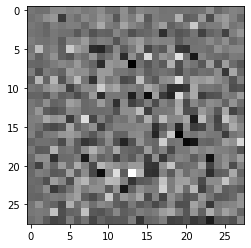

In [8]:
import matplotlib.pyplot as plt

plt.imshow(gen_img[0, :, :, 0], cmap="gray")

In [9]:
def make_discriminator():
    model = tf.keras.Sequential([
        ly.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
        ly.LeakyReLU(),
        ly.Dropout(0.3),
        
        ly.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        ly.LeakyReLU(),
        ly.Dropout(0.3),
        
        ly.Flatten(),
        ly.Dense(1)
    ])
    return model

In [10]:
discriminator = make_discriminator()

In [11]:
decision = discriminator(gen_img)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00179352]], dtype=float32)>

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metoda określa ilościowo, jak dobrze dyskryminator jest w stanie odróżnić prawdziwe obrazy od podróbek

Porwnuje przewidywania dyskriminatora dotyczce rzeczywistych obrazw z tablic jedynek, a przewidywania dyskryminatora dotyczce faszywych (generowanych obrazów z tablicą zer.

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator loss określa ilościowo, jak dobre był on  w stanie oszukać dyskryminator. Intuicyjnie, jeśli generator działa dobrze, dyskryminator sklasyfikuje fałszywe obrazy jako rzeczywiste (lub 1). Tutaj porównamy decyzje dyskryminatorów na wygenerowanych obrazach z tablicą jedynek.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [17]:
EPOCHS = 50
noise_dims = 100
num_examples = 16

seed = tf.random.normal([num_examples, noise_dims])

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dims])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_imgs, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    grads_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grads_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grads_discriminator, discriminator.trainable_variables))    

In [26]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for img_batch in dataset:
            train_step(img_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print(f"Time for {epoch+1} is {time.time()-start} sec")
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [29]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
    plt.savefig(f"img_epoch{epoch}.png")
    plt.show()

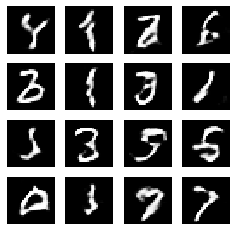

In [30]:
train(train_dataset, EPOCHS)

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [33]:
def display_image(epoch):
    return PIL.Image.open(f"img_epoch{epoch}.png")

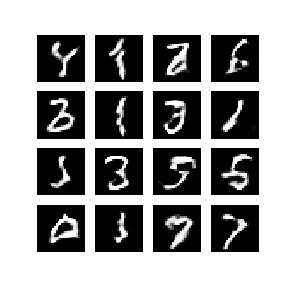

In [34]:
display_image(EPOCHS)

In [36]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob("img*.png")
    filenames = sorted(filenames)
    
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


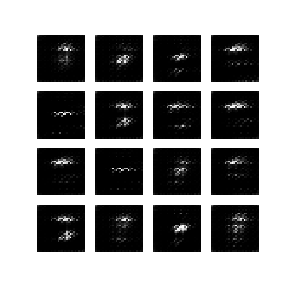

In [39]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)